# Demo CSV --> Graph Notebook

This notebooks demonstrates the data flow of generating a graph from a CSV file. 

In [1]:
import os

import json
import pandas as pd
import regex as re

from neo4j_runway.modeler import GraphDataModeler
from neo4j_runway.discovery import Discovery
from neo4j_runway.llm import LLM

## Initialize Test Data

In [2]:
USER_GENERATED_INPUT = {
    'General Description': 'This is data on different countries.',
    'id': 'unique id for a country.',
    'name': 'the country name.',
    'phone_code': 'country area code.',
    'capital': 'the capital of the country.',
    'currency_name': "name of the country's currency",
    'region': 'primary region of the country.',
    'subregion': 'subregion location of the country.',
    'timezones': 'timezones contained within the country borders.',
    'latitude': 'the latitude coordinate of the country center.',
    'longitude': 'the longitude coordinate of the country center.'
}

In [3]:
data = pd.read_csv("data/csv/countries.csv")

## Initialize LLM

In [4]:
llm = LLM()

In [5]:
disc = Discovery(llm=llm, 
                      user_input=USER_GENERATED_INPUT, 
                      data=data
                      )

In [6]:
discovery = disc.run()
print(discovery)

Based on the provided summary of your dataset, here are some key observations and insights regarding the characteristics of your data:

### General Overview
- Your dataset consists of information on 250 countries, with a total of 10 features for each country. These features include both numerical and categorical data types, providing a comprehensive overview of various country attributes such as geographical, political, and economic characteristics.

### Data Completeness
- Most of your columns are fully populated, with `id`, `name`, `phone_code`, `currency_name`, `timezones`, `latitude`, and `longitude` having no missing values across all 250 entries. This indicates a high level of data completeness for these attributes.
- There are a few columns with missing values: `capital` (5 missing), `region` (2 missing), and `subregion` (3 missing). These missing values are relatively few in number and could potentially be filled in with additional research or inferred from other data sources i

In [7]:
gdm = GraphDataModeler(
    llm=llm,
    user_input=USER_GENERATED_INPUT,
    discovery=disc.discovery,
    general_data_description=disc.general_description,
    categorical_data_description=disc.categorical_data_description,
    numeric_data_description=disc.numeric_data_description,
    feature_descriptions=disc.feature_descriptions
)

In [8]:
initial_model = gdm.create_initial_model()
print(initial_model)

recieved a valid response
nodes=[Node(label='Country', properties=[Property(name='id', type='int', csv_mapping='id', is_unique=True), Property(name='name', type='str', csv_mapping='name', is_unique=False)]), Node(label='Capital', properties=[Property(name='capital', type='str', csv_mapping='capital', is_unique=True)]), Node(label='Currency', properties=[Property(name='currencyName', type='str', csv_mapping='currency_name', is_unique=False)]), Node(label='Region', properties=[Property(name='region', type='str', csv_mapping='region', is_unique=False)]), Node(label='Subregion', properties=[Property(name='subregion', type='str', csv_mapping='subregion', is_unique=False)]), Node(label='Timezone', properties=[Property(name='timezones', type='str', csv_mapping='timezones', is_unique=False)])] relationships=[Relationship(type='HAS_CAPITAL', properties=[], source='Country', target='Capital'), Relationship(type='USES_CURRENCY', properties=[], source='Country', target='Currency'), Relationship(ty

In [9]:
gdm.current_model

DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', csv_mapping='id', is_unique=True), Property(name='name', type='str', csv_mapping='name', is_unique=False)]), Node(label='Capital', properties=[Property(name='capital', type='str', csv_mapping='capital', is_unique=True)]), Node(label='Currency', properties=[Property(name='currencyName', type='str', csv_mapping='currency_name', is_unique=False)]), Node(label='Region', properties=[Property(name='region', type='str', csv_mapping='region', is_unique=False)]), Node(label='Subregion', properties=[Property(name='subregion', type='str', csv_mapping='subregion', is_unique=False)]), Node(label='Timezone', properties=[Property(name='timezones', type='str', csv_mapping='timezones', is_unique=False)])], relationships=[Relationship(type='HAS_CAPITAL', properties=[], source='Country', target='Capital'), Relationship(type='USES_CURRENCY', properties=[], source='Country', target='Currency'), Relationship(type='LOCATED_IN_

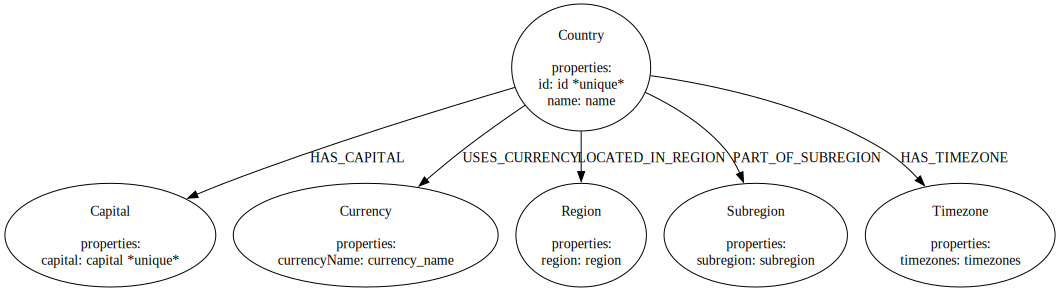

In [11]:
gdm.current_model.visualize()

In [12]:
print(gdm.model_history[-1].validate_model(csv_columns=list(USER_GENERATED_INPUT.keys())[1:])['message'])

In [16]:
gdm.iterate_model(iterations=1, user_corrections="Make Region node have a HAS_SUBREGION relationship with Subregion node. Remove The relationship between Country and Region.")

recieved a valid response


DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', csv_mapping='id', is_unique=True), Property(name='name', type='str', csv_mapping='name', is_unique=False), Property(name='phoneCode', type='str', csv_mapping='phone_code', is_unique=False), Property(name='latitude', type='float', csv_mapping='latitude', is_unique=False), Property(name='longitude', type='float', csv_mapping='longitude', is_unique=False)]), Node(label='Capital', properties=[Property(name='name', type='str', csv_mapping='capital', is_unique=True)]), Node(label='Currency', properties=[Property(name='name', type='str', csv_mapping='currency_name', is_unique=True)]), Node(label='Region', properties=[Property(name='name', type='str', csv_mapping='region', is_unique=True)]), Node(label='Subregion', properties=[Property(name='name', type='str', csv_mapping='subregion', is_unique=True)]), Node(label='Timezone', properties=[Property(name='name', type='str', csv_mapping='timezones', is_unique=True)]

In [17]:
gdm.current_model

DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', csv_mapping='id', is_unique=True), Property(name='name', type='str', csv_mapping='name', is_unique=False), Property(name='phoneCode', type='str', csv_mapping='phone_code', is_unique=False), Property(name='latitude', type='float', csv_mapping='latitude', is_unique=False), Property(name='longitude', type='float', csv_mapping='longitude', is_unique=False)]), Node(label='Capital', properties=[Property(name='name', type='str', csv_mapping='capital', is_unique=True)]), Node(label='Currency', properties=[Property(name='name', type='str', csv_mapping='currency_name', is_unique=True)]), Node(label='Region', properties=[Property(name='name', type='str', csv_mapping='region', is_unique=True)]), Node(label='Subregion', properties=[Property(name='name', type='str', csv_mapping='subregion', is_unique=True)]), Node(label='Timezone', properties=[Property(name='name', type='str', csv_mapping='timezones', is_unique=True)]

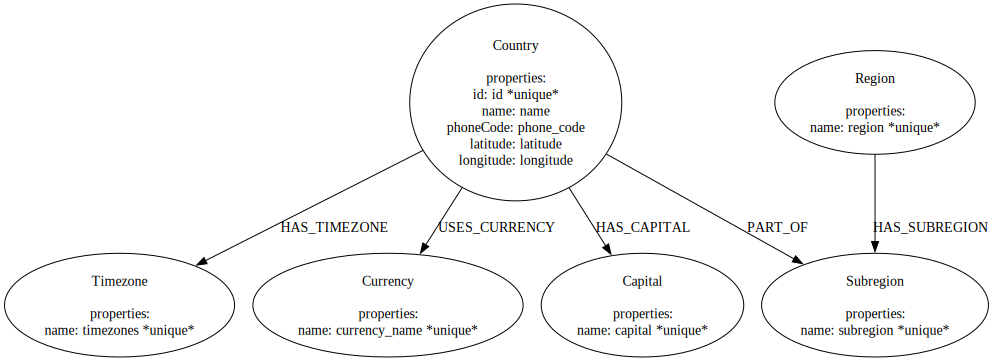

In [18]:
gdm.current_model.visualize()